In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
import glob
import os
import requests
import time
import warnings

warnings.simplefilter('ignore', FutureWarning)

from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# sns.set_style(style='whitegrid')
device_num = 0
#torch.cuda.set_device(device_num)#####################################################
from google.colab import drive
import shutil
import random


In [ ]:
tqdm.pandas()

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %%time
# #for file in onlyfiles:
# shutil.copy(f"/content/drive/MyDrive/CURS_22_DF/16_11_df_signals.pkl", '/content/')

In [ ]:
# %%time
# df = pd.read_pickle('16_11_df_signals.pkl').drop(['signal','msg','fc','fs','T'],axis = 1)
# df

In [ ]:
shutil.copy('/content/drive/MyDrive/CURS_22_DF/19_12_scale_df_signals.pkl', '/content/',  )

'/content/19_12_scale_df_signals.pkl'

In [ ]:
df = pd.read_pickle('19_12_scale_df_signals.pkl')
df

,type_sig,signal_IQ
0,PSK_2,"[(0.7059837322161113-0.7082280493218339j), (-0..."
0,PSK_2,"[(-0.8728823514927556-0.487930733252659j), (-0..."
0,PSK_2,"[(0.44848191175040925+0.8937919080147785j), (0..."
0,PSK_2,"[(0.5286214672583299-0.8488576702567107j), (-0..."
0,PSK_2,"[(0.8079779931435035-0.5892126633023059j), (-0..."
...,...,...
0,QAM_256,"[(-0.03005561565198769-0.059507179501505844j),..."
0,QAM_256,"[(-0.6602920525129635-0.41581641896046706j), (..."
0,QAM_256,"[(-0.2235837042777474+0.3636379372448136j), (-..."
0,QAM_256,"[(0.42779005460406133-0.5156399500336869j), (0..."


In [ ]:
def noise( x, N):
        snr_dB=N
        snr = 10**(snr_dB/10)
        sigmaN2 = 1/snr

        # generate AWGN
        n = (sigmaN2**0.5)*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))
        return x + n

def make_noise(df, N):
    df_w = df.copy()
    df_w['signal_IQ'] = df_w['signal_IQ'].apply(lambda x: noise(x, N))
    return df_w

def moment(x,p,q):
    return np.mean(x**(p-q) * x.conjugate()**q)
def cumulant(x,p,q):
        if p == 2:
            return moment(x,p,q)
        elif p == 4:
            if q == 0:
                return moment(x,4,0) - 3 * moment(x,2,0) **2
            elif q == 1:
                return moment(x,4,1) - 3 * moment(x,2,1) **2
            return moment(x,4,2) - moment(x,2,0).real**2 - 2 * moment(x,2,1) **2

def make_mom_cum(df):
    df_out = df.copy()
    df_cols_name = []
    moments_num = [[1, 0], [2, 0], [2, 1], [3, 0], [3, 1], [3, 2], [4, 0]]
    for num in (moments_num):
        df_cols_name.append(f'moment_{num[0]}_{num[1]}')
        df_out[df_cols_name[-1]] = df_out.signal_IQ.apply(lambda x: moment(x,num[0], num[1]))
    cumulants_num = [(2,0),(2,1),(4,0),(4,1),(4,2)]
    for num in (cumulants_num):
        df_cols_name.append(f'cumulants_{num[0]}_{num[1]}')
        df_out[df_cols_name[-1]] = df_out.signal_IQ.apply(lambda x: cumulant(x,num[0], num[1]))

    return df_out

In [ ]:
def plot_hue(df):
    w,h = 15,5
    plt.subplots(figsize = (w,h))
    
    df_long = pd.melt(df,['type_sig'],var_name = 'type', value_name = 'val')
    sns.boxplot(data = df_long,
                x = 'val',
                y = 'type',
                hue = 'type_sig')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import CatBoostClassifier

In [ ]:
acc = {}
for SNR in tqdm(range(25,26)):
    noise_sig = make_noise(df,SNR)
    df_train = make_mom_cum(noise_sig)
    X = df_train.drop(['type_sig','signal_IQ'],axis =1)
    y = df_train['type_sig']
    le = preprocessing.LabelEncoder()
    X = X.applymap(lambda x: x.real)
    
    y1 = le.fit_transform(y)
    X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(
        X, y1, test_size=0.2, random_state=21,
        shuffle=True, stratify=y
    )
    scaler = MinMaxScaler()
    X_train_in = scaler.fit_transform(X_train_in)
    X_test_in = scaler.transform(X_test_in)
    df_add = pd.DataFrame()

    cat = CatBoostClassifier(iterations = 800,
                           task_type="GPU",
                           devices='0:1')
    cat.fit(X_train_in,y_train_in,
        use_best_model = True,
        silent = True,
        
        eval_set = (X_test_in,y_test_in))
    acc[SNR] = {}
    y_pred = cat.predict(X_test_in)
    acc[SNR]['accuracy_score'] = accuracy_score(y_test_in, y_pred)
    acc[SNR]['classification_report'] = classification_report(y_test_in, y_pred, output_dict = True)
    acc[SNR]['confusion_matrix'] = confusion_matrix(y_test_in, y_pred)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
%%timeit -n100 -r3
cat.predict(X_test_in[:1])

383 µs ± 37 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [ ]:
cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MultiClass',
 'iterations': 800,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': True,
 'class_names': [0, 1, 2, 3, 4, 5, 6, 7],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'MultiClass',
 'learning_r

In [ ]:
import codecs, json 

In [ ]:
acc_t = acc

In [ ]:
acc_t = acc
for key in acc_t.keys():
    #acc[key]['accuracy_score'] = accuracy_score(y_test_in, y_pred)
    #acc_t[key]['classification_report'] = acc_t[key]['classification_report'].to_list()
    acc_t[key]['confusion_matrix'] = acc_t[key]['confusion_matrix'].tolist()

with open('result_catboost.json', 'w') as f:
    json.dump(acc_t, f)

In [ ]:
for key in acc.keys():
    #acc[key]['accuracy_score'] = accuracy_score(y_test_in, y_pred)
    #acc_t[key]['classification_report'] = acc_t[key]['classification_report'].to_list()
    acc[key]['confusion_matrix'] = np.array(acc[key]['confusion_matrix'])

In [ ]:
pd.DataFrame(acc[30]['classification_report'])

,0,1,2,3,4,5,6,7,accuracy,macro avg,weighted avg
precision,0.978261,1.0,1.0,0.998333,1.0,0.993333,0.975083,0.993333,0.992292,0.992293,0.992293
recall,0.975000,1.0,1.0,0.998333,1.0,0.993333,0.978333,0.993333,0.992292,0.992292,0.992292
f1-score,0.976628,1.0,1.0,0.998333,1.0,0.993333,0.976705,0.993333,0.992292,0.992292,0.992292
support,600.000000,600.0,600.0,600.000000,600.0,600.000000,600.000000,600.000000,0.992292,4800.000000,4800.000000


In [ ]:
conf_m = pd.DataFrame(acc[25]['confusion_matrix'], index = le.inverse_transform([0,1,2,3,4,5,6,7]), columns = le.inverse_transform([0,1,2,3,4,5,6,7]))

In [ ]:
conf_m = conf_m[['PSK_2','PSK_4','PSK_8','PSK_16','QAM_4','QAM_16','QAM_64','QAM_256']].loc[['PSK_2','PSK_4','PSK_8','PSK_16','QAM_4','QAM_16','QAM_64','QAM_256']]

In [ ]:
conf_m

,PSK_2,PSK_4,PSK_8,PSK_16,QAM_4,QAM_16,QAM_64,QAM_256
PSK_2,600,0,0,0,0,0,0,0
PSK_4,0,600,0,0,0,0,0,0
PSK_8,0,0,599,1,0,0,0,0
PSK_16,0,0,0,585,15,0,0,0
QAM_4,0,0,0,12,588,0,0,0
QAM_16,0,0,0,0,0,600,0,0
QAM_64,0,0,0,0,0,0,592,8
QAM_256,0,0,0,0,0,0,4,596


In [ ]:
int(vmax_2/8)

60

[0, 60, 120, 180, 240, 300, 360, 420, 480]

Text(167.7, 0.5, 'Предсказанные')

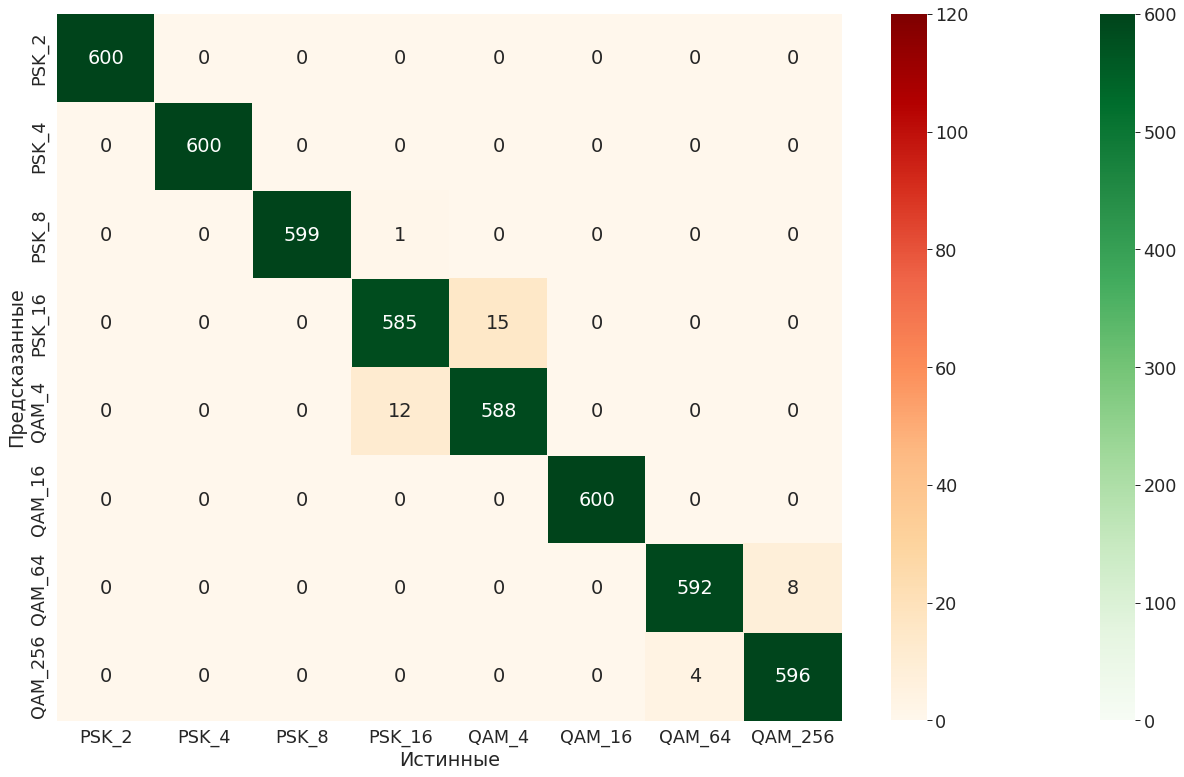

In [ ]:
cf_matrix = np.array(conf_m)
vmin = np.min(cf_matrix)
vmax = np.max(cf_matrix)
vmax_2 = 600*0.2
off_diag_mask = np.eye(*cf_matrix.shape, dtype=bool)
#plt.subplots()
fig = plt.figure(figsize = (22,13))
sns.heatmap(conf_m, annot=True,  mask=~off_diag_mask, cmap='Greens', vmin=vmin, vmax=vmax, fmt=".0f")
sns.heatmap(conf_m, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax_2, cbar_kws=dict(ticks=list(range(0, int(vmax_2)+1, int(vmax_2/6) ))))
plt.xlabel("Истинные")
plt.ylabel("Предсказанные")

AttributeError: ignored

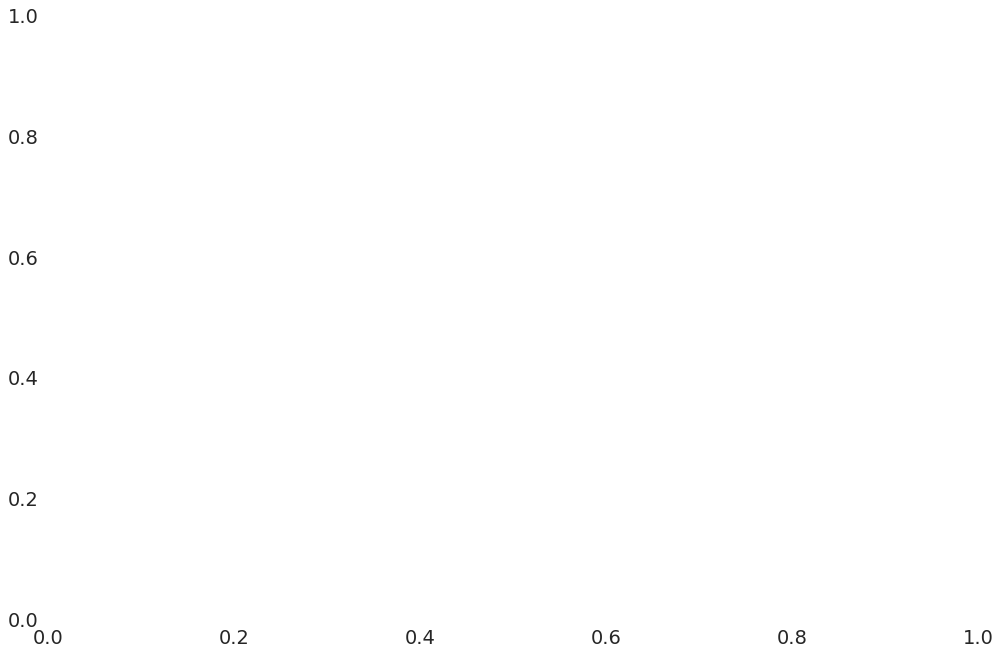

In [ ]:
plt.figure(figsize=(15, 10), dpi=80)
sns.heatmap(conf_m, annot=True, cmap='Greens', fmt=".0f", scale=None)

In [ ]:
arr = []
for key in tqdm(acc.keys()):
    matrix = acc[key]['confusion_matrix']
    arr.append((matrix.diagonal()/matrix.sum(axis=0)))

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
accuracy_class = pd.DataFrame(arr, index = acc.keys(), columns = le.inverse_transform([0,1,2,3,4,5,6,7]))

In [ ]:
accuracy_class.to_csv('df_CB_only.csv')

In [ ]:
accuracy_class.reset_index(inplace =True)

In [ ]:
accuracy_class = accuracy_class.rename(columns = {'index':'SNR'})

In [ ]:
df_long = pd.melt(accuracy_class,['SNR'],var_name = 'type_sig', value_name = 'accuracy')
#df_long

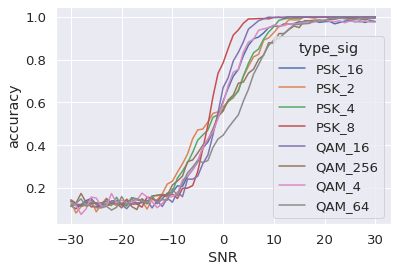

In [ ]:
sns.lineplot(data = df_long, x = 'SNR', y = 'accuracy', hue = 'type_sig')


v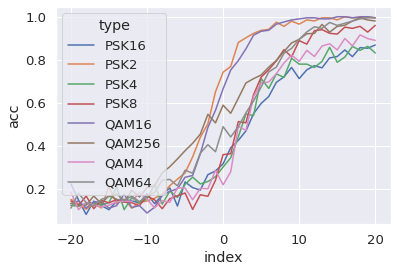



In [ ]:
import plotly.express as px

fig = px.line(df_long, x = 'SNR', y = 'accuracy', color = 'type_sig', symbol="type_sig")
#fig.update_traces(mode='markers+lines')
fig.show()

In [ ]:
# X = dict_classes[key]['X']
# y = dict_classes[key]['y']

In [ ]:
# pd.concat([y, X],axis =1)

In [ ]:
def plot_hue(df):
    w,h = 40,20
    plt.subplots(figsize = (w,h))
    
    df_long = pd.melt(df,['type_sig'],var_name = 'type', value_name = 'val')
    sns.boxplot(data = df_long,
                x = 'val',
                y = 'type',
                hue = 'type_sig')

In [ ]:
noise_sig = make_noise(df,20)
df_train = make_mom_cum(noise_sig)
X = df_train.drop(['type_sig','signal_IQ'],axis =1)
y = df_train['type_sig']

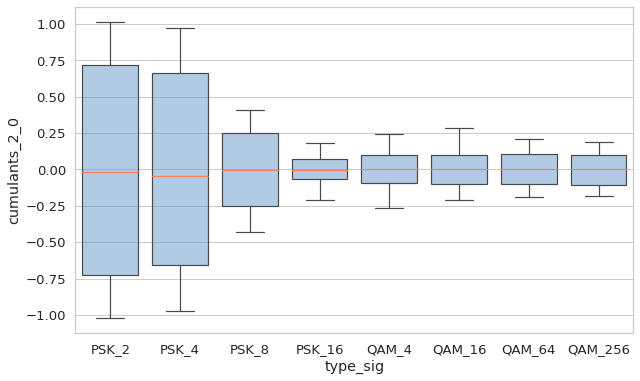

In [ ]:
plt.subplots(figsize = (10,6))
sns.set_style("whitegrid")
sns.set_style('white')
sns.set_context('paper', font_scale=2)

sns.boxplot(data = df_p,
                x = 'type_sig',
                y = 'cumulants_2_0',
                #hue = 'type_sig',notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
            )

In [ ]:
df_p = pd.concat([y, X.applymap(lambda x:x.real)],axis =1)
df_p = df_p[['type_sig','cumulants_2_0',
       'cumulants_2_1', 'cumulants_4_0', 'cumulants_4_1', 'cumulants_4_2']]
df_plot = pd.DataFrame()
for col in df_p.columns[1:]:
    df_add = df_p[[col,'type_sig']].rename(columns = {col:'CM'})
    df_add['CM_type'] = col.replace('cumulants_','C ').replace('_',',')
    df_plot = pd.concat([df_plot, df_add])

df_plot

,CM,type_sig,CM_type
0,-0.007023,PSK_2,"C 2,0"
0,0.517968,PSK_2,"C 2,0"
0,-0.607426,PSK_2,"C 2,0"
0,-0.435749,PSK_2,"C 2,0"
0,0.299441,PSK_2,"C 2,0"
...,...,...,...
0,-0.154594,QAM_256,"C 4,2"
0,-0.129350,QAM_256,"C 4,2"
0,-0.157249,QAM_256,"C 4,2"
0,-0.163423,QAM_256,"C 4,2"


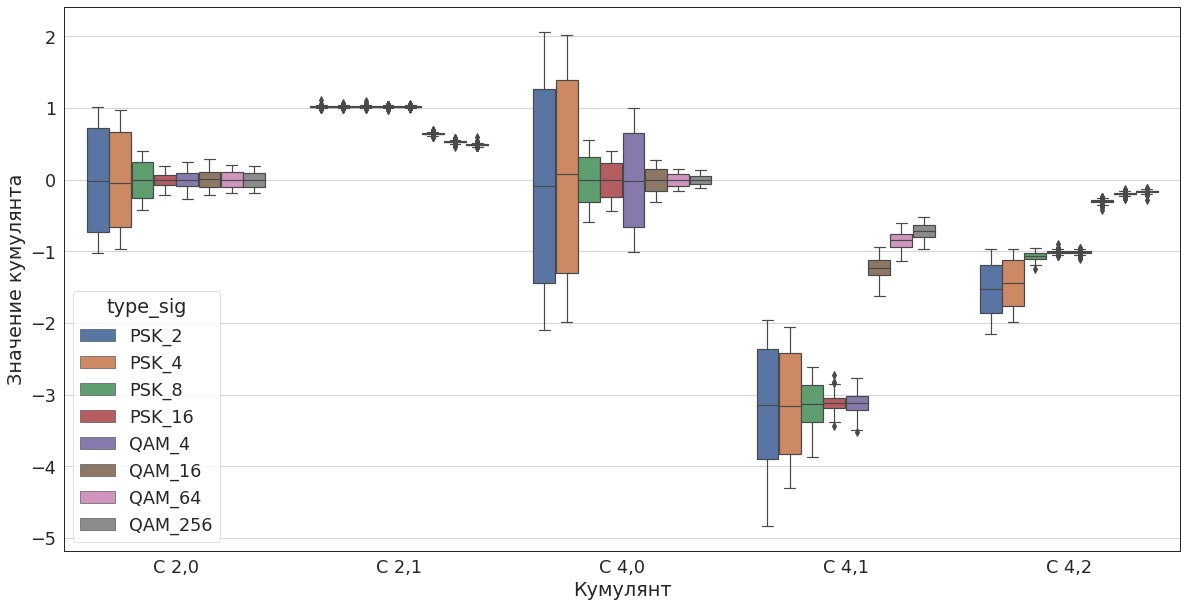

In [ ]:

fig, ax = plt.subplots(figsize = (20,10))
sns.set_style("whitegrid")
sns.set_style('white')
sns.set_context('paper', font_scale=2)

box = sns.boxplot(data = df_plot,
                x = 'CM_type',
                y = 'CM',
                hue = 'type_sig',
                whis = 1.5,
                dodge = True,
    # flierprops={"marker": "x"},
    # boxprops={"facecolor": (.4, .6, .8, .5)},
    # medianprops={"color": "coral"},
            ).set(
    xlabel='Кумулянт',
    ylabel='Значение кумулянта'
)
ax.yaxis.grid(True,'both') # Hide the horizontal gridlines
ax.xaxis.grid(False) # Show the vertical gridlines

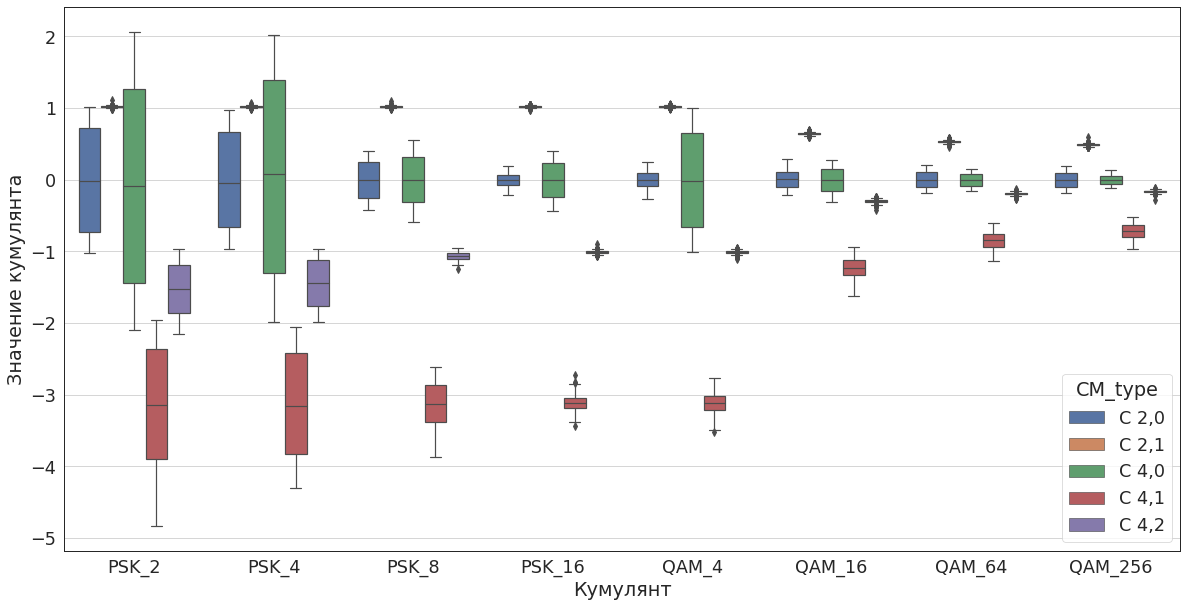

In [ ]:

fig, ax = plt.subplots(figsize = (20,10))
sns.set_style("whitegrid")
sns.set_style('white')
sns.set_context('paper', font_scale=2)

box = sns.boxplot(data = df_plot,
                x = 'type_sig',
                y = 'CM',
                hue = 'CM_type',
                whis = 1.5,
                dodge = True,
    # flierprops={"marker": "x"},
    # boxprops={"facecolor": (.4, .6, .8, .5)},
    # medianprops={"color": "coral"},
            ).set(
    xlabel='Кумулянт',
    ylabel='Значение кумулянта'
)
ax.yaxis.grid(True,'both') # Hide the horizontal gridlines
ax.xaxis.grid(False) # Show the vertical gridlines

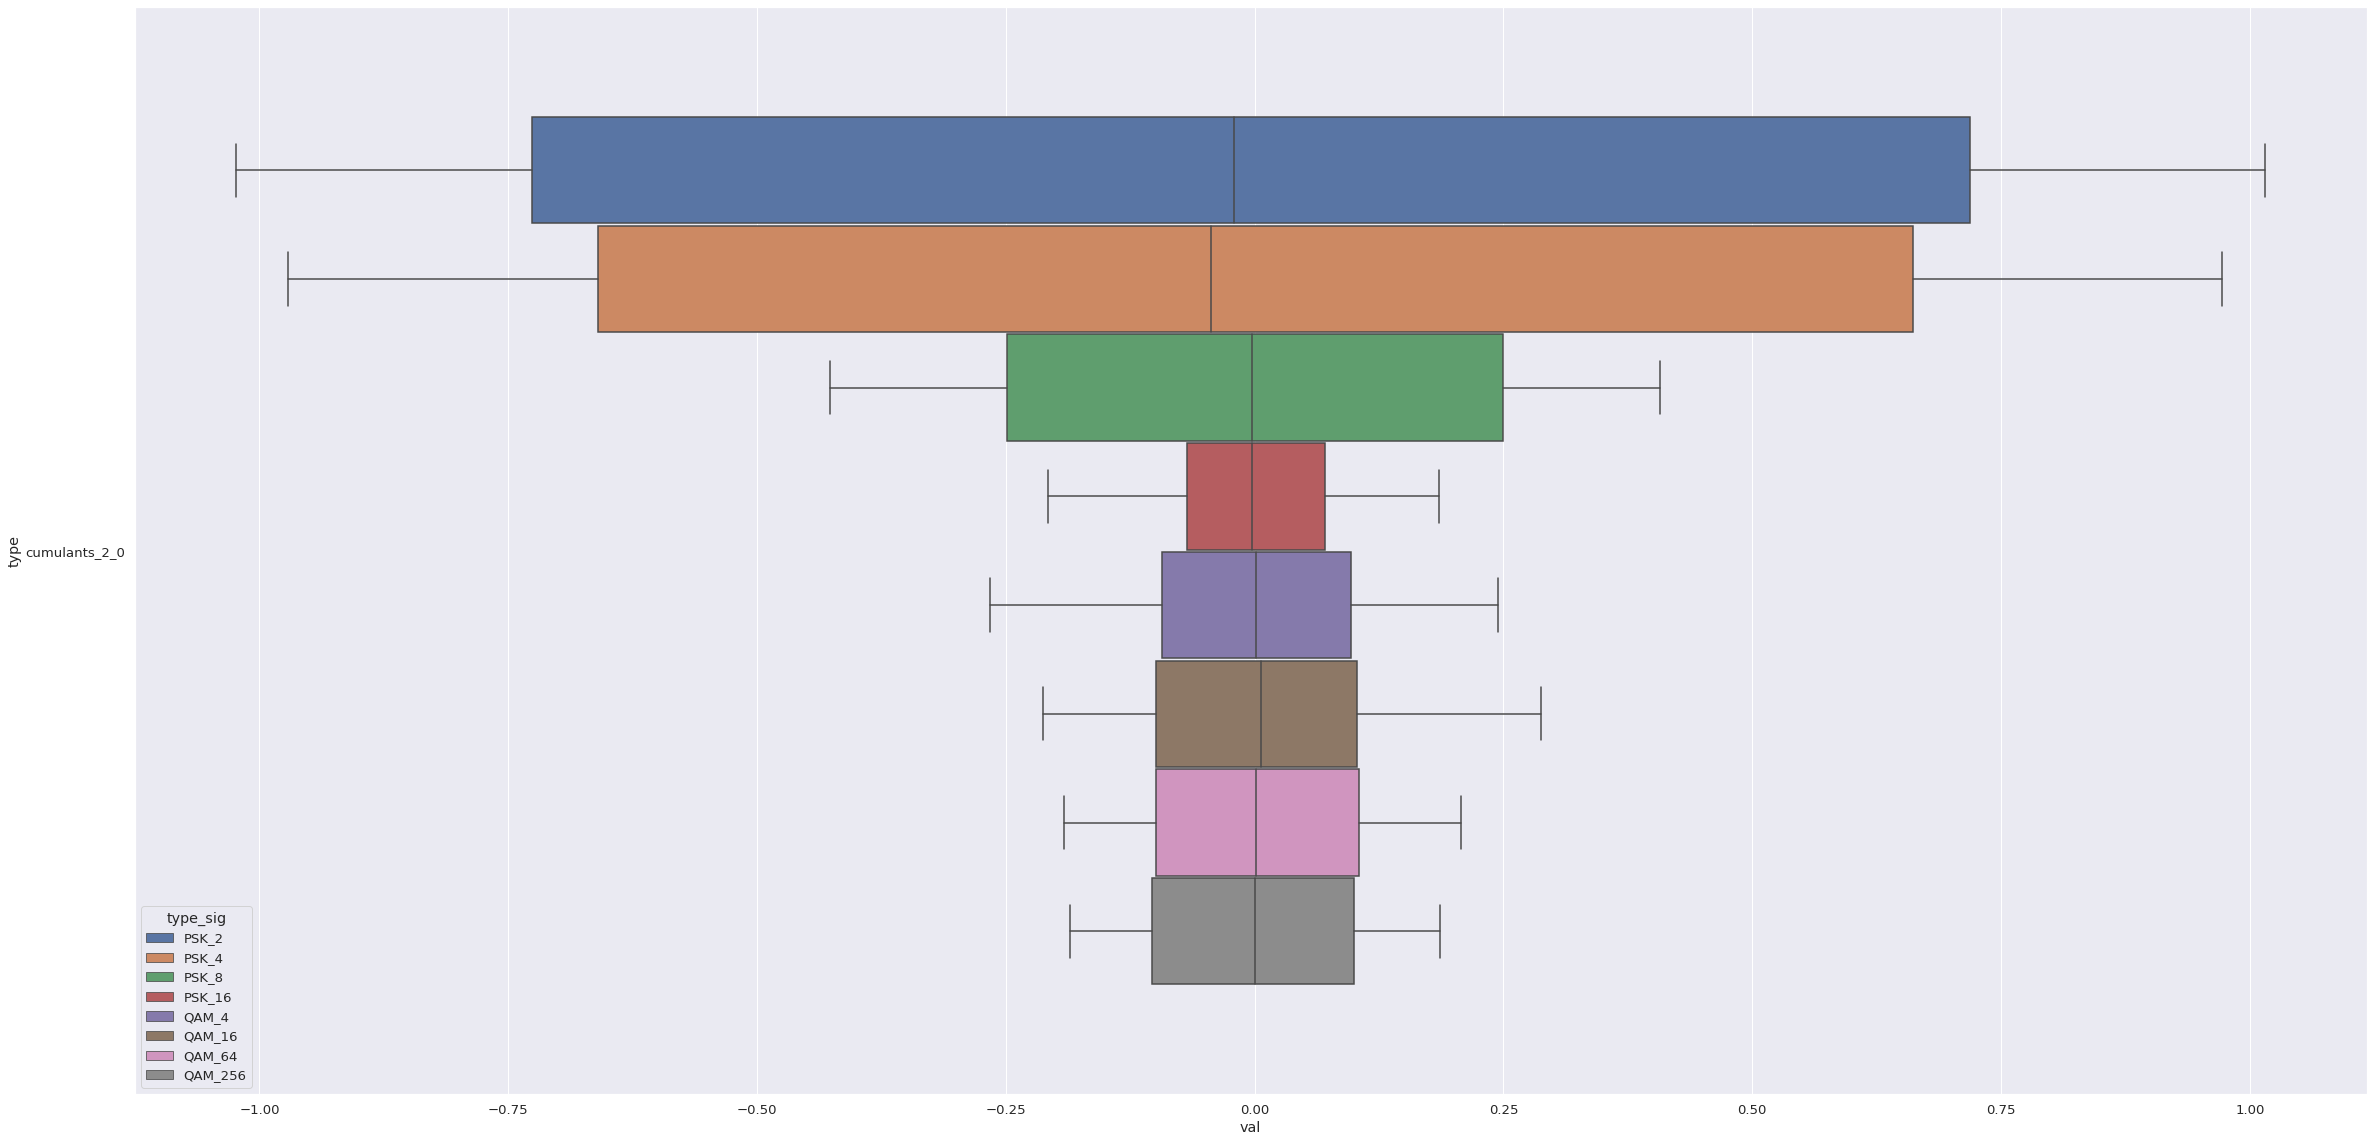

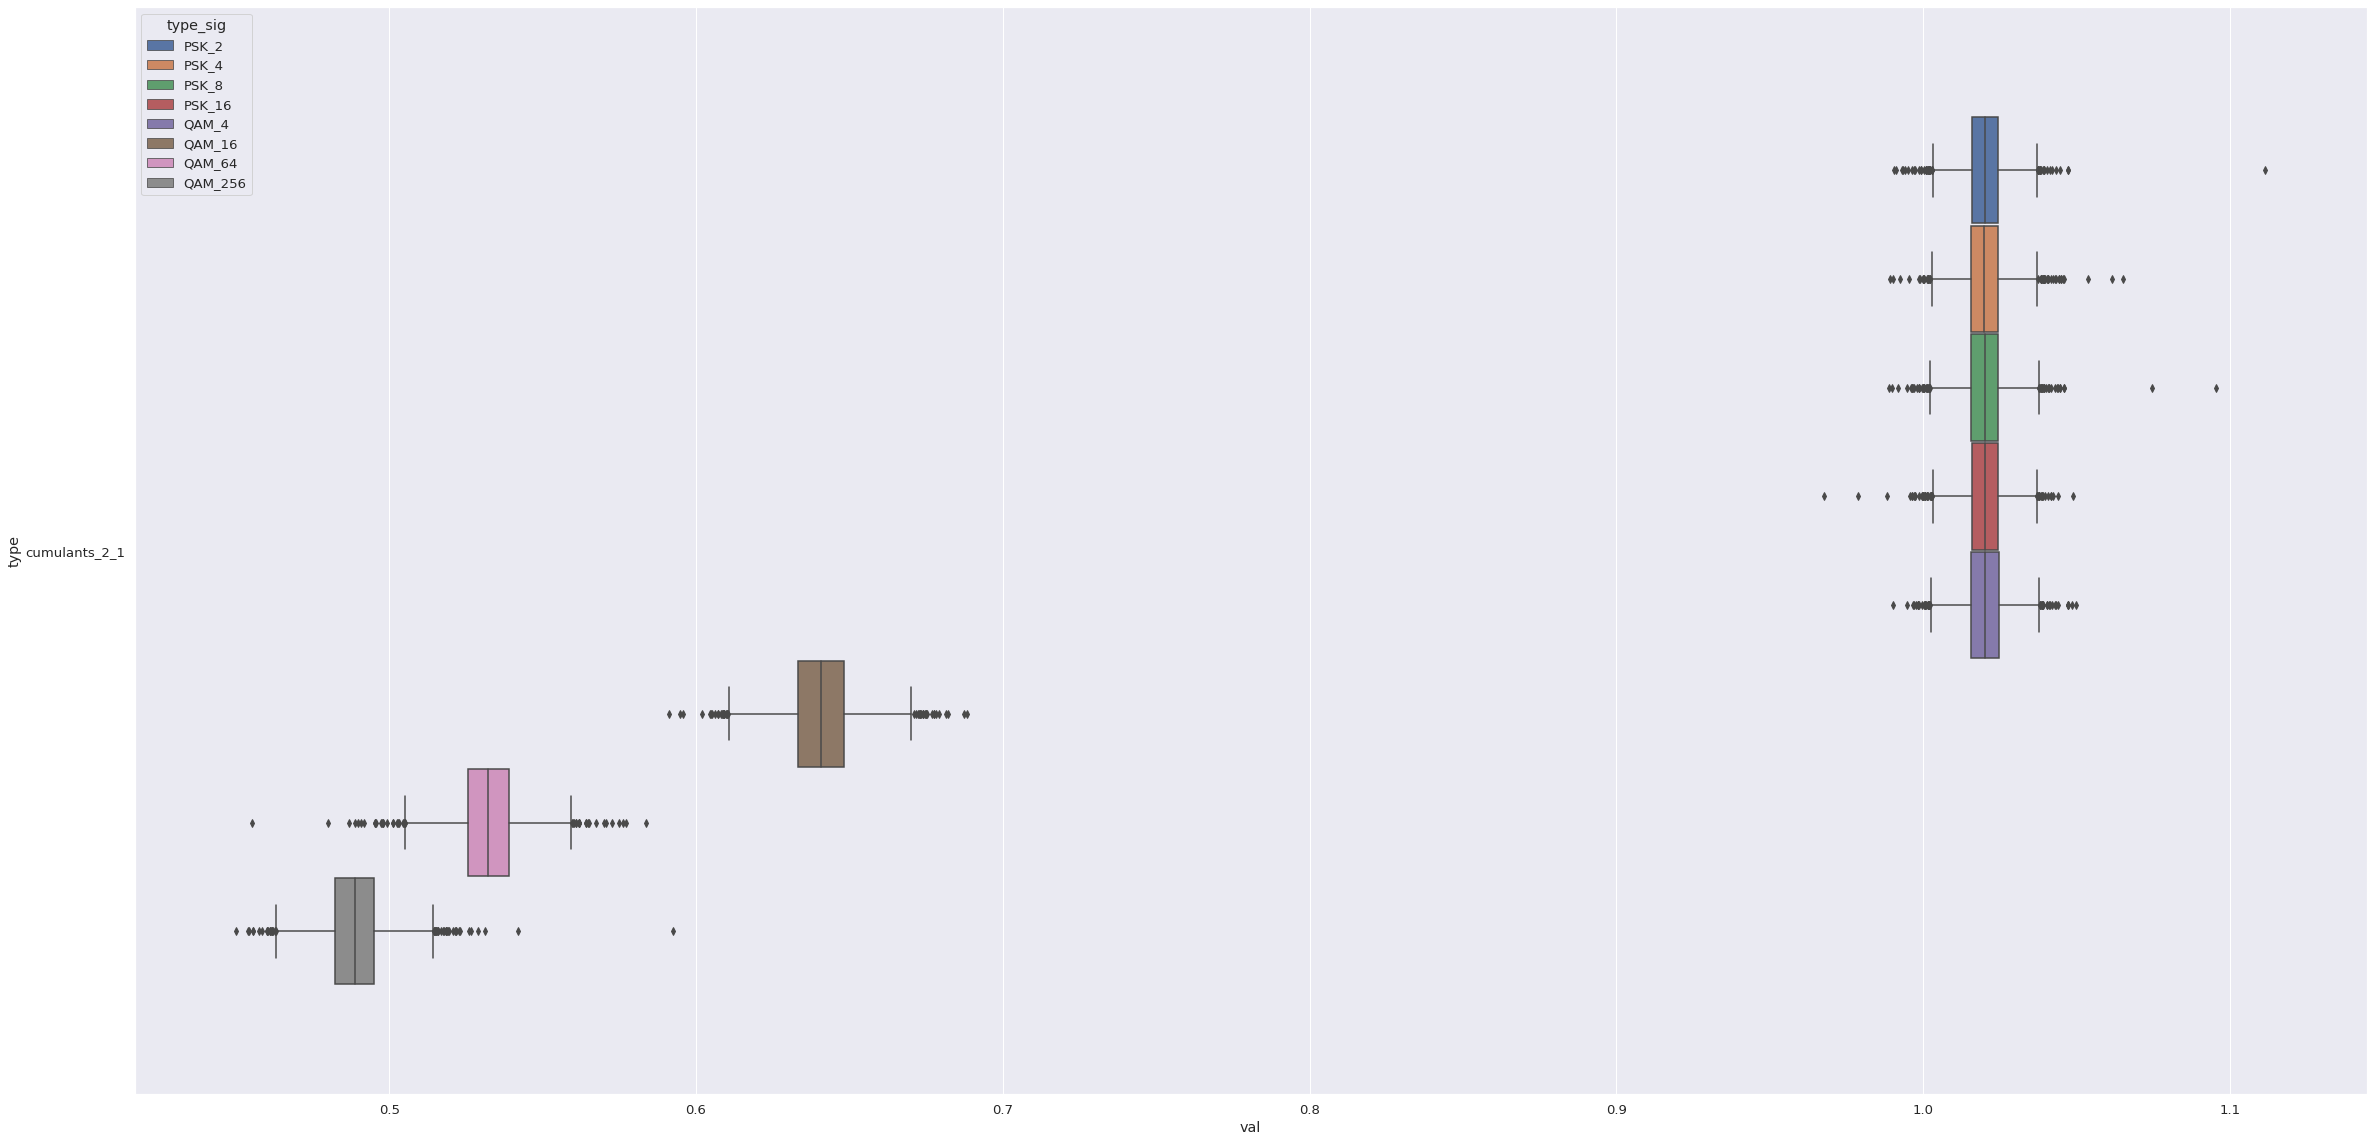

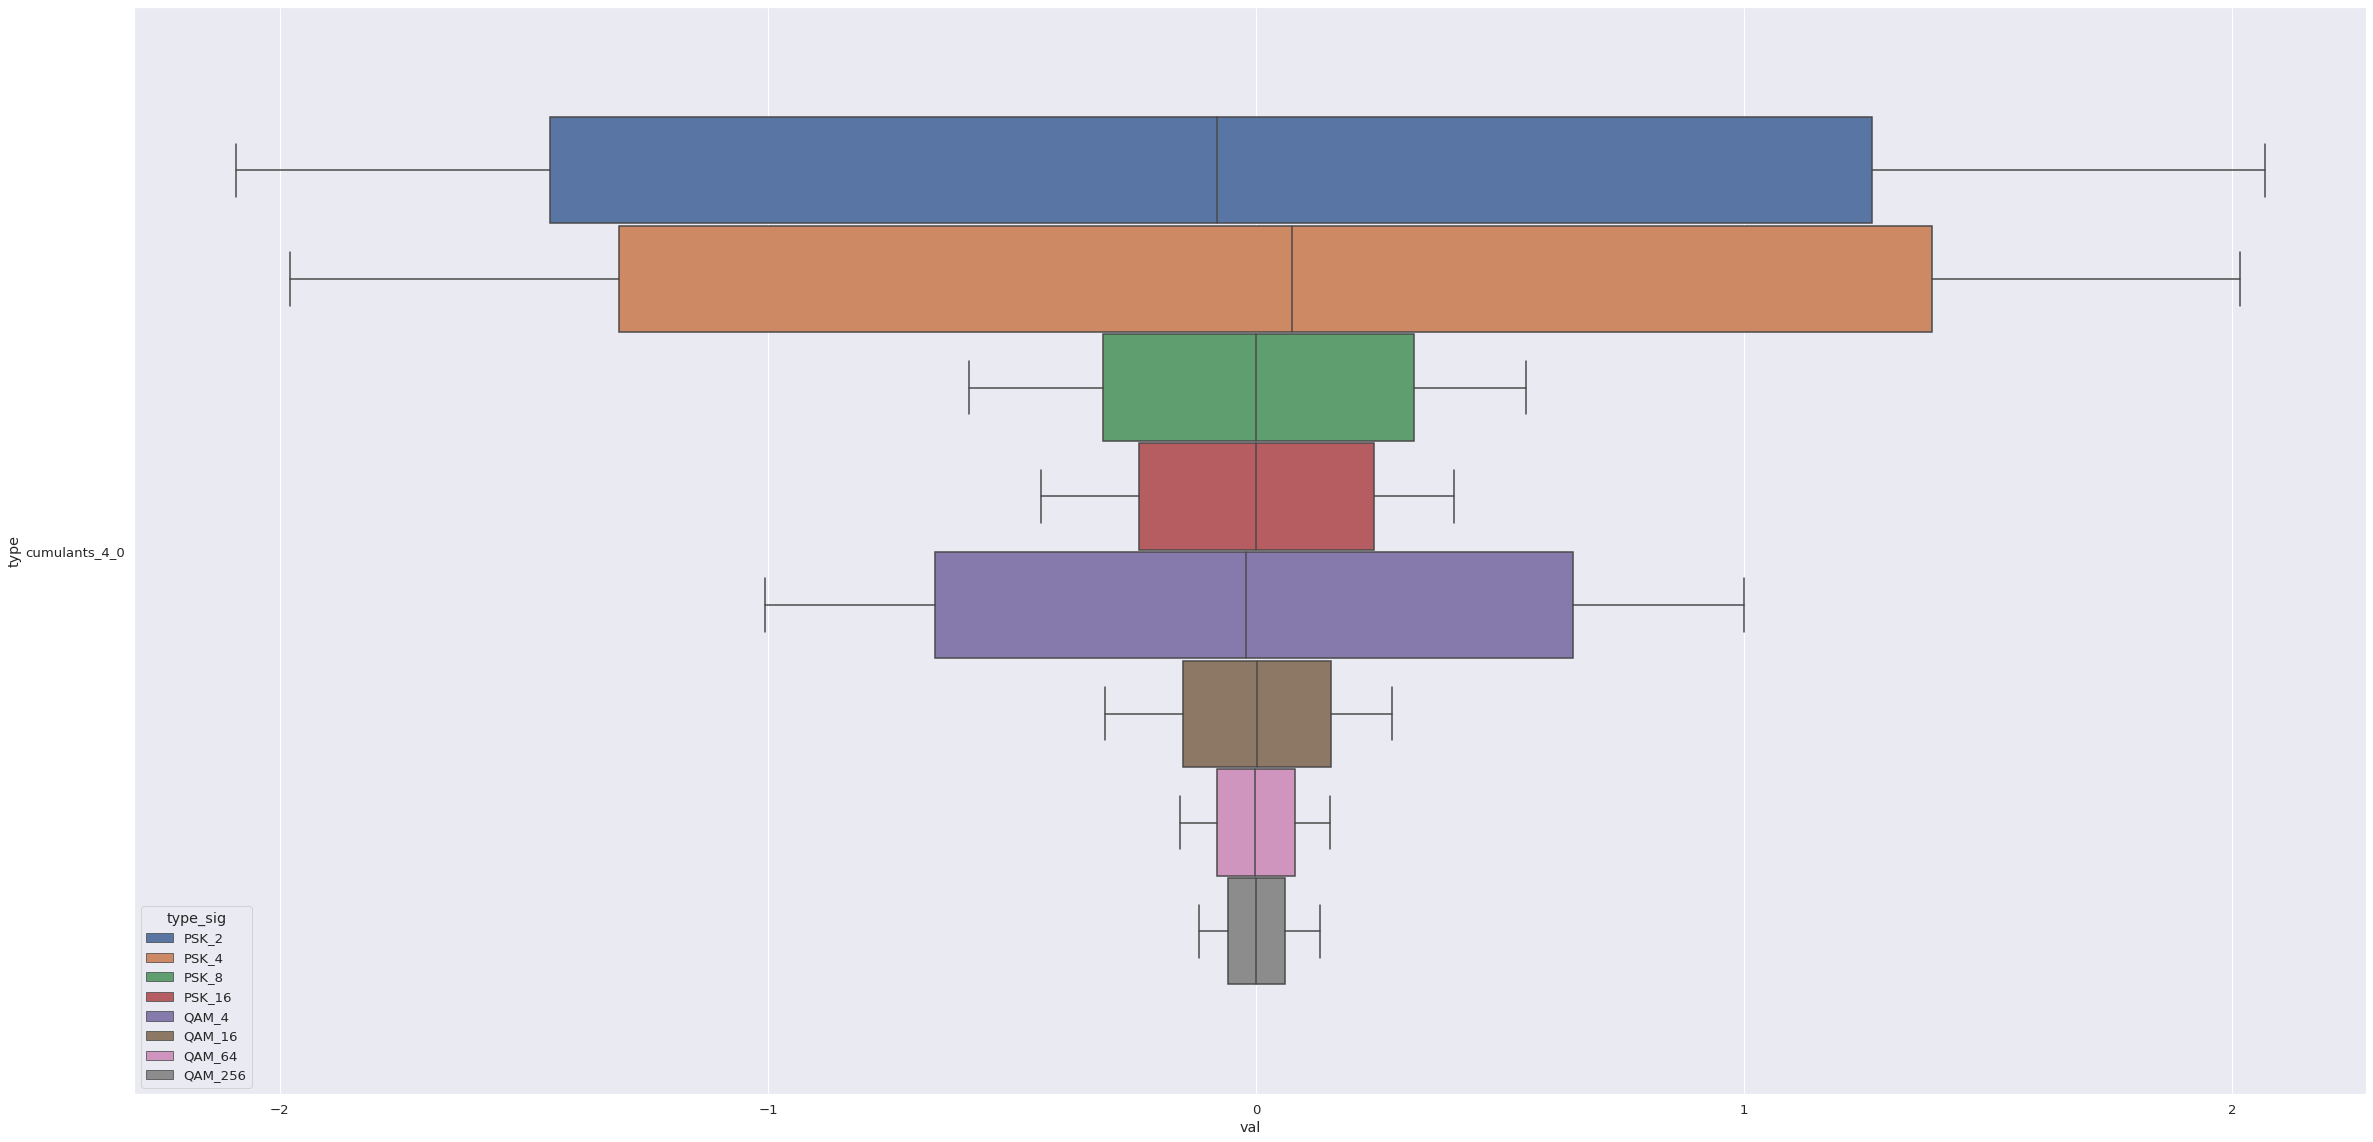

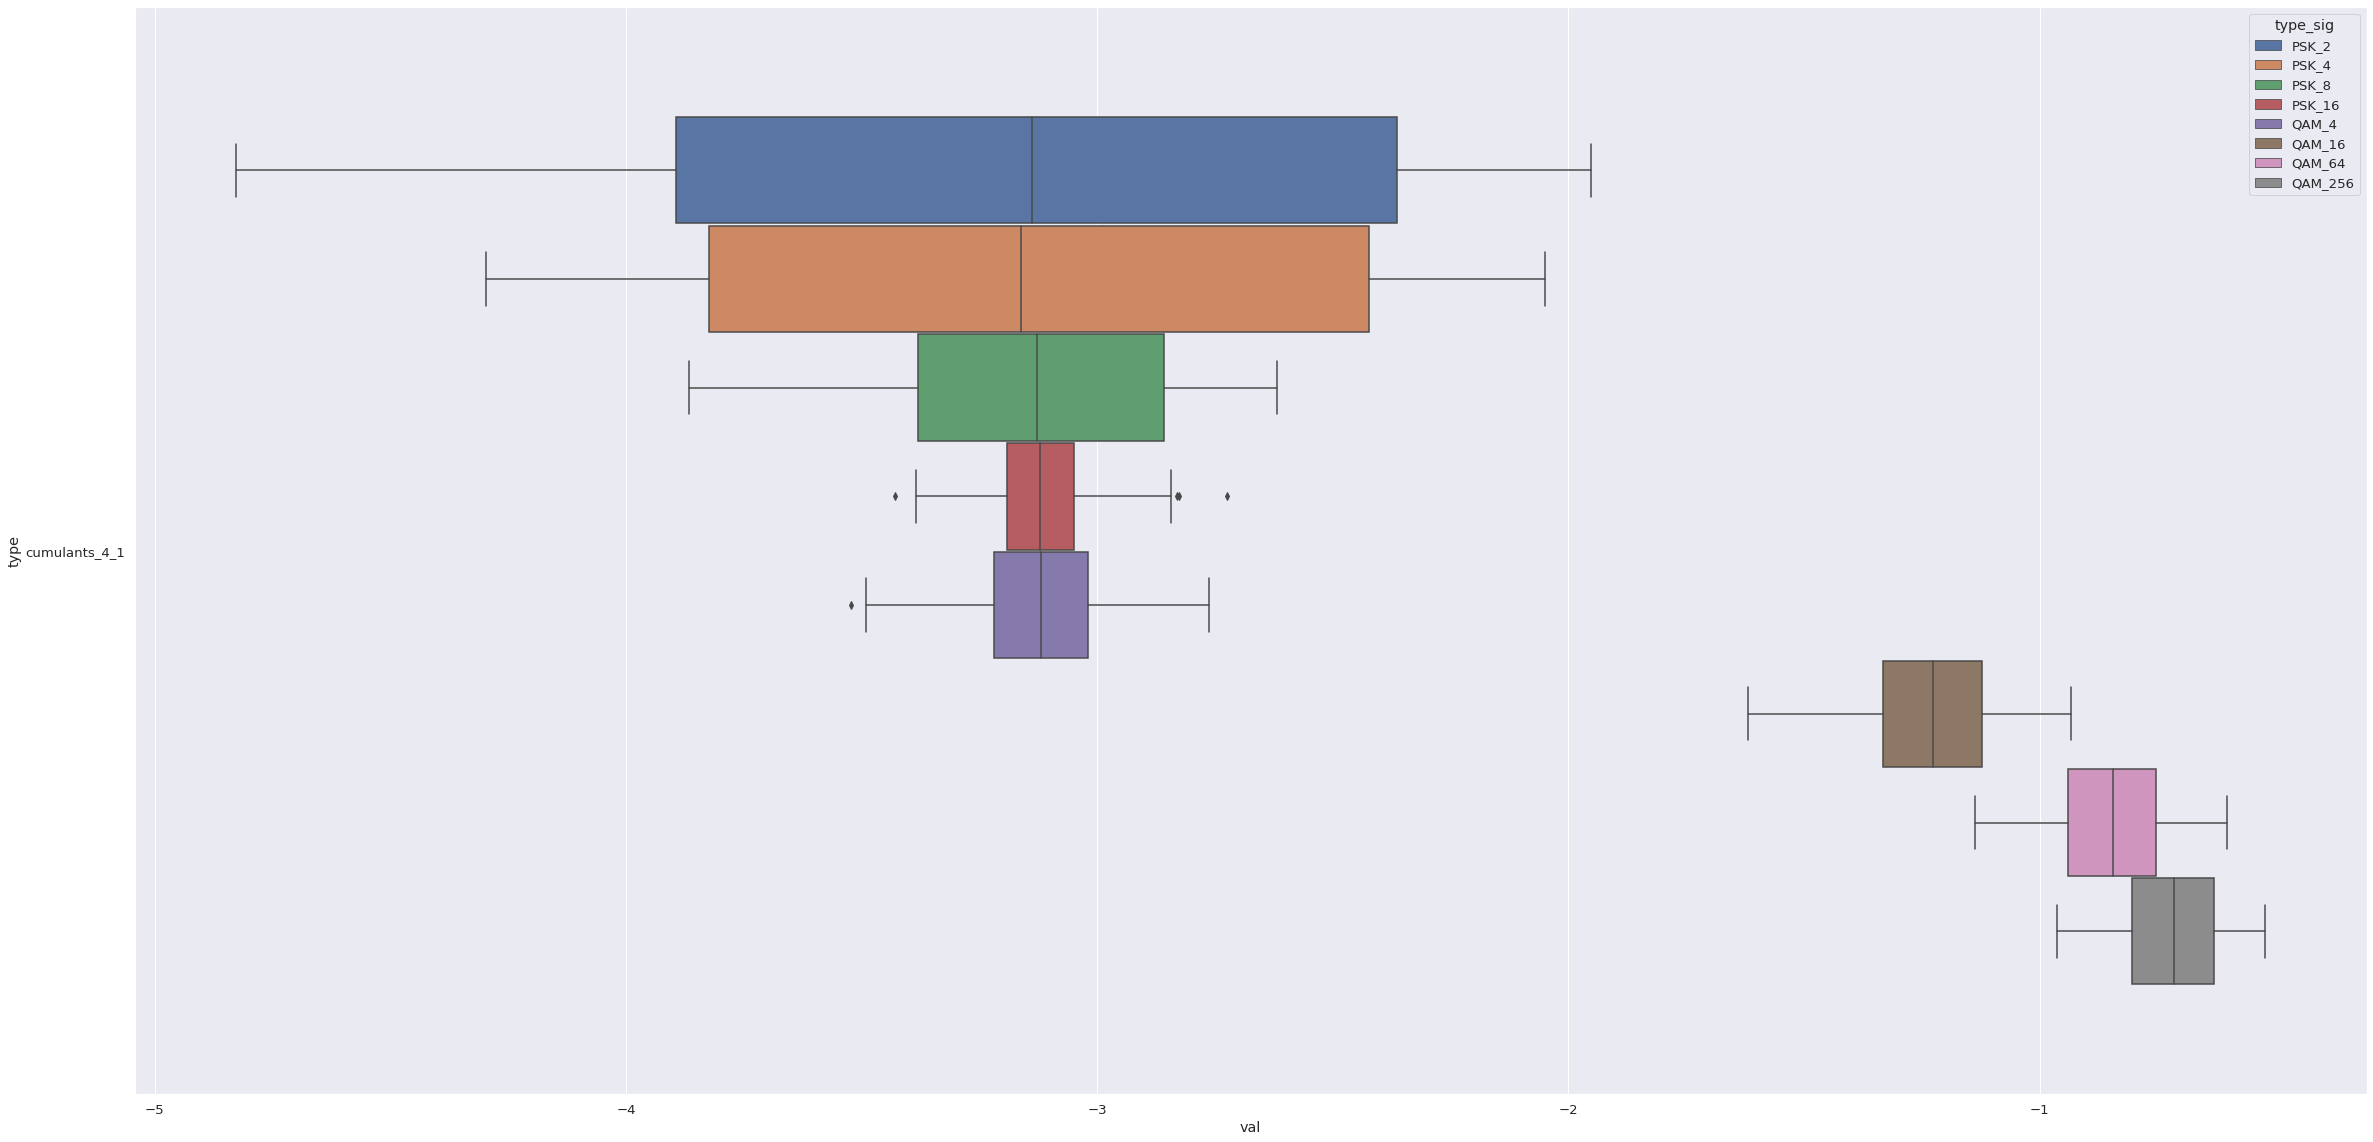

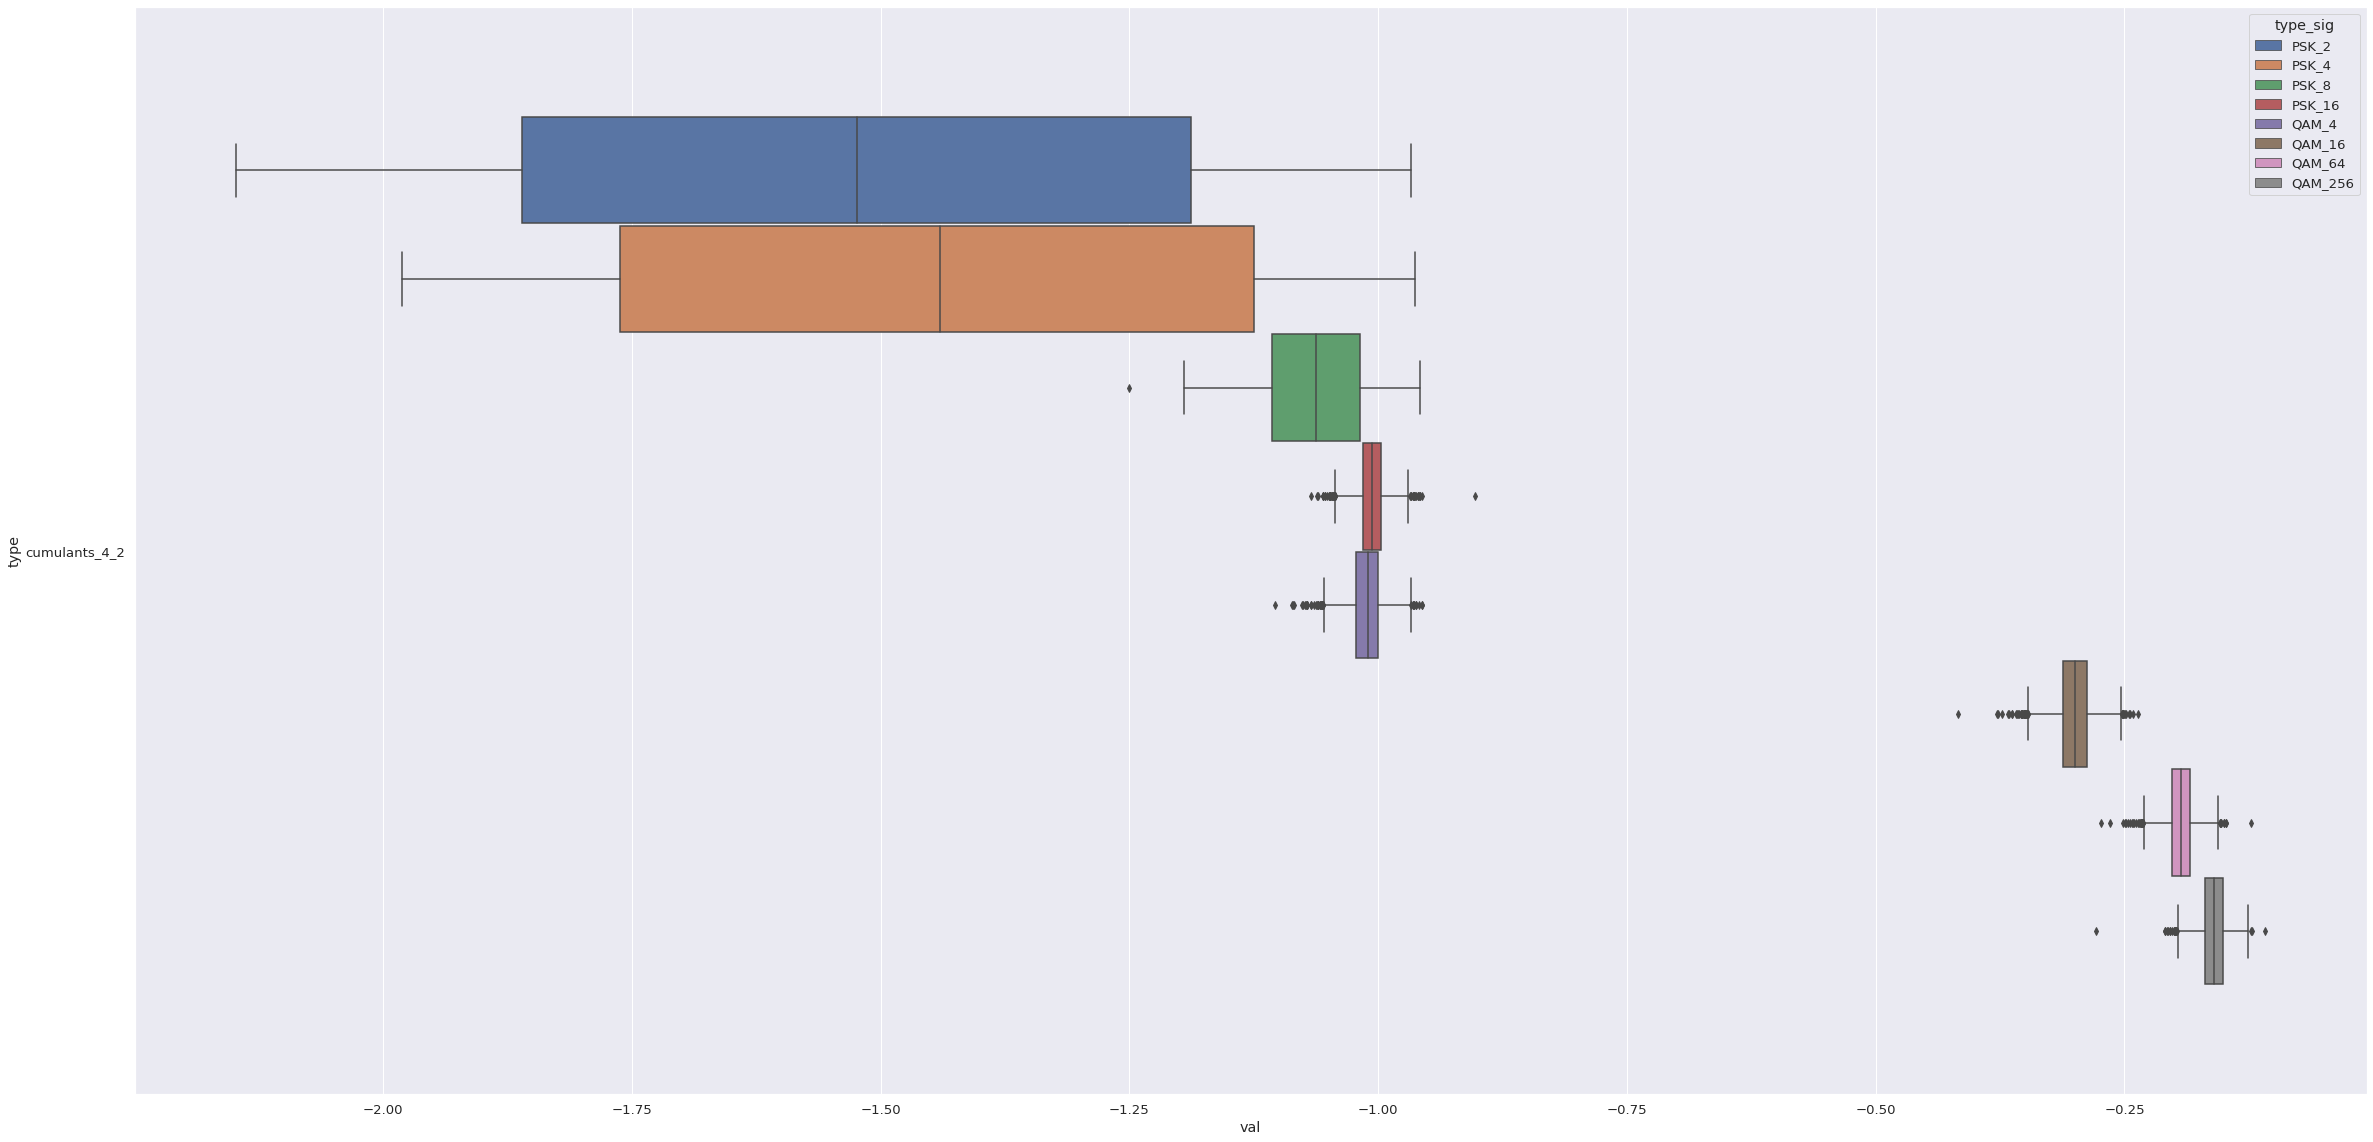

In [ ]:
df_p = pd.concat([y, X.applymap(lambda x:x.real)],axis =1)
df_p = df_p[['type_sig','cumulants_2_0',
       'cumulants_2_1', 'cumulants_4_0', 'cumulants_4_1', 'cumulants_4_2']]
for col in df_p.columns[1:]: 
    plot_hue(df_p[[col,'type_sig']]) 

In [ ]:
#cat.plot_tree(tree_idx = 799)

In [ ]:
df_long.to_csv('df_CB_only.csv')

In [ ]:
from google.colab import files
files.download('df_CB_only.csv')

In [ ]:
shutil.copy('/content/df_CB_only.csv', '/content/drive/MyDrive/CURS_22_DF/ )

In [ ]:
import plotly.express as px

fig = px.line(df_long, x = 'SNR', y = 'accuracy', color = 'type_sig', symbol="type_sig",
              title="Точность классификации CatBoostClassifier")
fig.show()

In [ ]:
arr_accuracy_score = []
for key in tqdm(acc.keys()):
    arr_accuracy_score.append(acc[key]['accuracy_score'])

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
np.mean(arr_accuracy_score)

0.5679576502732241

In [ ]:
fig = px.line(pd.DataFrame({'SNR':acc.keys(), 'accuracy':arr_accuracy_score}), x = 'SNR', y = 'accuracy', markers=True,
              title="Точность классификации CatBoostClassifier")
fig.show()